In [1]:
import os
import sys
import time

import astropy.units as u
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline

project_path = "/Users/adrian/projects/kingkong/"
if project_path not in sys.path:
    sys.path.append(project_path)
import kingkong

In [2]:
# first generate stream data
np.random.seed(42)
mock = kingkong.MockStream(r0=9., v0=0.5, nsteps_per_period=128, 
                           quaternion=kingkong.Quaternion.random())

# Note: no intrinsic thickness to the stream

# observational uncertainties
V_obs = np.zeros_like(mock.Y)
V_obs[:,0] = 1E-5
V_obs[:,1] = 1E-5
V_obs[:,2] = 0.1 * mock.Y[:,2] # 10% distance error
V_obs[:,3] = (1*u.mas/u.yr).to(u.rad/u.Myr).value
V_obs[:,4] = (1*u.mas/u.yr).to(u.rad/u.Myr).value
V_obs[:,5] = (1.*u.km/u.s).to(u.kpc/u.Myr).value
V_obs = V_obs**2.

data_nstars = 8
ix = np.random.randint(mock.K, size=data_nstars)
data = kingkong.Data(mock.Y[ix], V_obs[ix])
data_X = mock.X[ix]

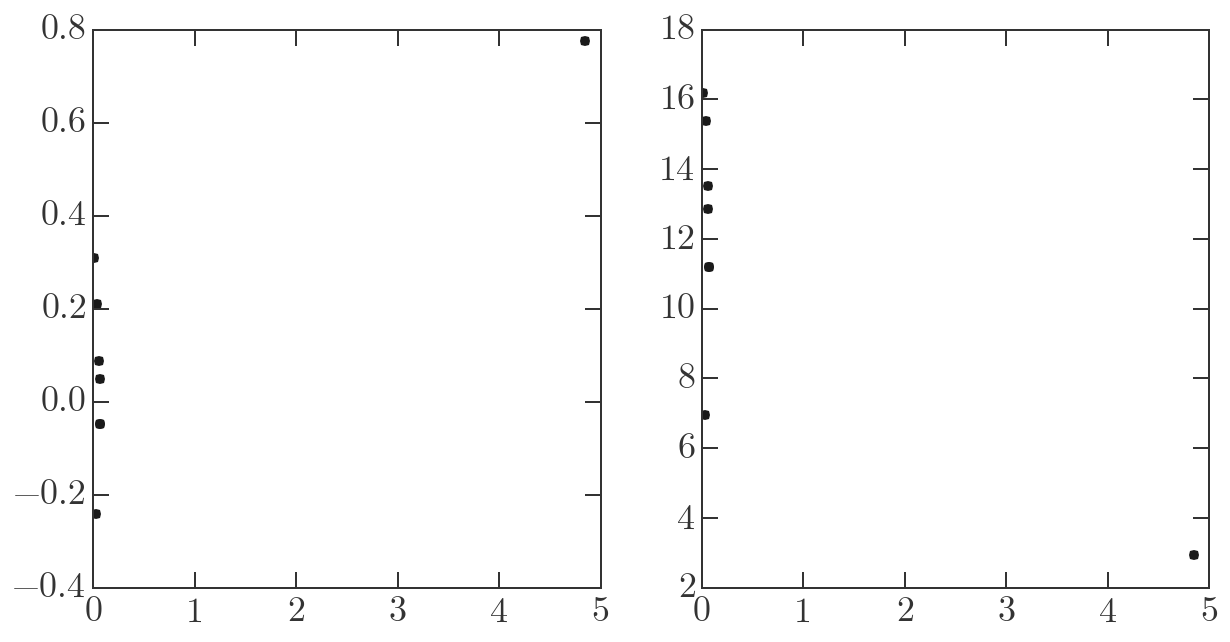

In [3]:
fig,axes = pl.subplots(1,2,figsize=(10,5))
axes[0].plot(data.Y[:,0], data.Y[:,1], ls='none', marker='o')
axes[1].plot(data.Y[:,0], data.Y[:,2], ls='none', marker='o')

## Start sampling!

## BUG in velocity transformation

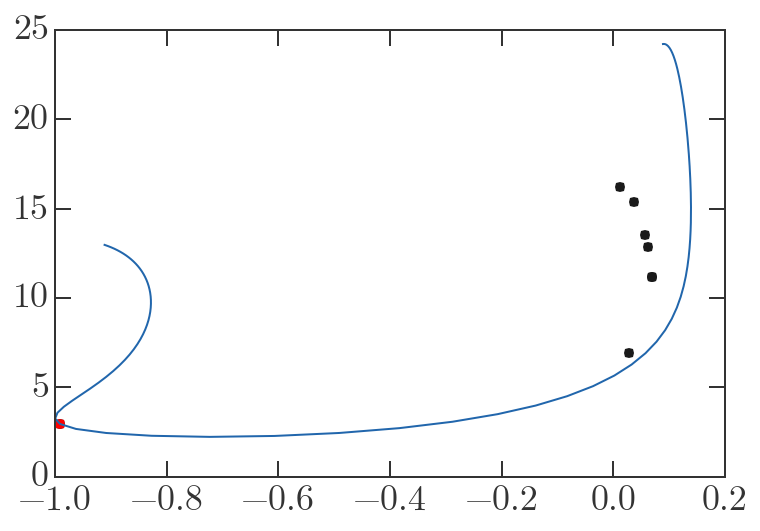

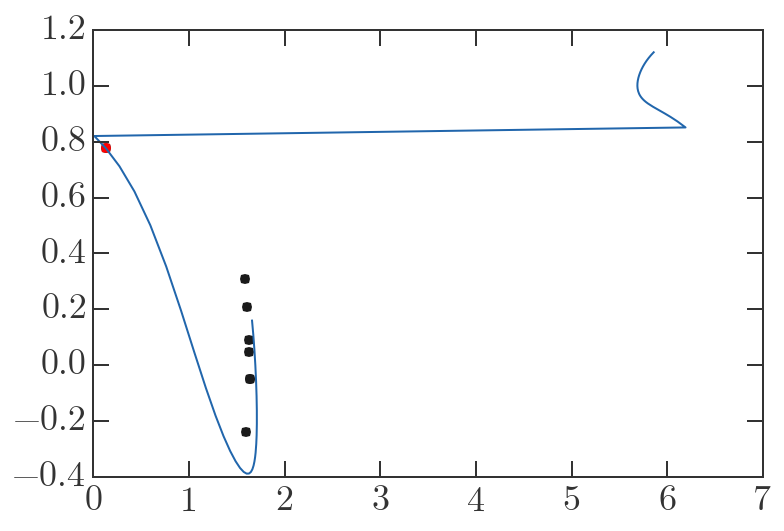

In [14]:
Xdata = kingkong.heliocentric_to_galactocentric(kingkong.spherical_to_cartesian(data.Y))
# assert np.all(Xdata == mock.X[ix])

t0 = time.time()
nsamples = 1024
nsteps_per_period = 128

np.random.seed(11)
for i in range(nsamples):    
    n,nprime = np.random.randint(data_nstars, size=2)
    k,kprime = np.random.randint(nsteps_per_period, size=2)
    v0 = np.random.uniform(0.05, 1.)
    
    _mock = kingkong.MockStream(r0=1., v0=v0, nsteps_per_period=nsteps_per_period, quaternion=None)
    assert _mock.X.shape[0] == nsteps_per_period
    
    X = _mock.X[:,:3]
    V = _mock.X[:,3:]
    Xk = X[k]
    Xkp = X[kprime]
    
    # THIS IS A HACK
    Xn = Xdata[n,:3]
    Xnp = Xdata[nprime,:3]
    
#     fig,axes = pl.subplots(1,2,figsize=(10,5))
#     axes[0].plot(_mock.X[:,0], _mock.X[:,1])
#     axes[1].plot(_mock.X[:,0], _mock.X[:,2])
    
#     fig,axes = pl.subplots(1,2,figsize=(10,5))
#     axes[0].plot(_mock.X[:,0+3], _mock.X[:,1+3])
#     axes[1].plot(_mock.X[:,0+3], _mock.X[:,2+3])

    rho_hat_par = Xk / np.sqrt(np.sum(Xk**2, axis=-1))
    r_hat_par = Xn / np.sqrt(np.sum(Xn**2, axis=-1))
    
    rho_cross = np.cross(rho_hat_par, Xkp)
    rho_hat_cross = rho_cross / np.sqrt(np.sum(rho_cross**2, axis=-1))
    rho_hat_perp = np.cross(rho_hat_cross, rho_hat_par)
    np.testing.assert_allclose(np.sqrt(np.sum(rho_hat_perp**2)), 1, atol=1E-15)
    np.testing.assert_allclose(np.dot(rho_hat_par, rho_hat_perp), 0., atol=1E-15)
    
    r_cross = np.cross(r_hat_par, Xnp)
    r_hat_cross = r_cross / np.sqrt(np.sum(r_cross**2, axis=-1))
    r_hat_perp = np.cross(r_hat_cross, r_hat_par)
    np.testing.assert_allclose(np.sqrt(np.sum(r_hat_perp**2)), 1, atol=1E-15)
    np.testing.assert_allclose(np.dot(r_hat_par, r_hat_perp), 0., atol=1E-15)
    
    _X = (r_hat_par[None] * np.dot(X, rho_hat_par)[:,None] + 
          r_hat_perp[None] * np.dot(X, rho_hat_perp)[:,None]) * np.sqrt(np.sum(Xn**2, axis=-1)) /  np.sqrt(np.sum(Xk**2, axis=-1))
    _V = (r_hat_par[None] * np.dot(V, rho_hat_par)[:,None] + 
          r_hat_perp[None] * np.dot(V, rho_hat_perp)[:,None]) # Note: Hogg only *barely* believes this
    _XV = np.hstack((_X, _V))
    _Y = kingkong.cartesian_to_spherical(kingkong.galactocentric_to_heliocentric(_XV))
    
#     fig,axes = pl.subplots(1,1)
#     axes.plot(data_X[:,0], data_X[:,1], marker='o', ls='none')
#     axes.plot(data_X[n,0], data_X[n,1], marker='o', color='r', ls='none')
#     axes.plot(_X[:,0], _X[:,1], marker=None, ls='-')
    
    fig,axes = pl.subplots(1,1)
    axes.plot(np.sin(data.Y[:,0]), data.Y[:,2], marker='o', ls='none')
    axes.plot(np.sin(data.Y[n,0]), data.Y[n,2], marker='o', color='r', ls='none')
    axes.plot(np.sin(_Y[:,0]), _Y[:,2], marker=None, ls='-')
    
    fig,axes = pl.subplots(1,1)
    axes.plot((data.Y[:,0]+np.pi/2.) % (2*np.pi), data.Y[:,1], marker='o', ls='none')
    axes.plot((data.Y[n,0]+np.pi/2.) % (2*np.pi), data.Y[n,1], marker='o', color='r', ls='none')
    axes.plot((_Y[:,0]+np.pi/2.) % (2*np.pi), _Y[:,1], marker=None, ls='-')
    
    break
    
    chisq_nk = _mock.compute_statistic(data)
    N = np.sum(chisq_nk.min(axis=1) < 10.) # Note: 10 is an arbitrary threshold
    
    if N > 0:
        print(i, N)
        
    if N == data_nstars:
        print("Found it:", i)
        print(time.time() - t0)
        break

---

In [3]:
r0s = np.linspace(5,15,64)
derps = np.zeros_like(r0s)
for i,r0 in enumerate(r0s):
    _mock = kingkong.MockStream(r0=r0, v0=0.5, nsteps_per_period=128, quaternion=mock.quaternion)
    chisq_nk = _mock.compute_statistic(data)
    derps[i] = np.sum(chisq_nk.min(axis=1) < 10.)

---

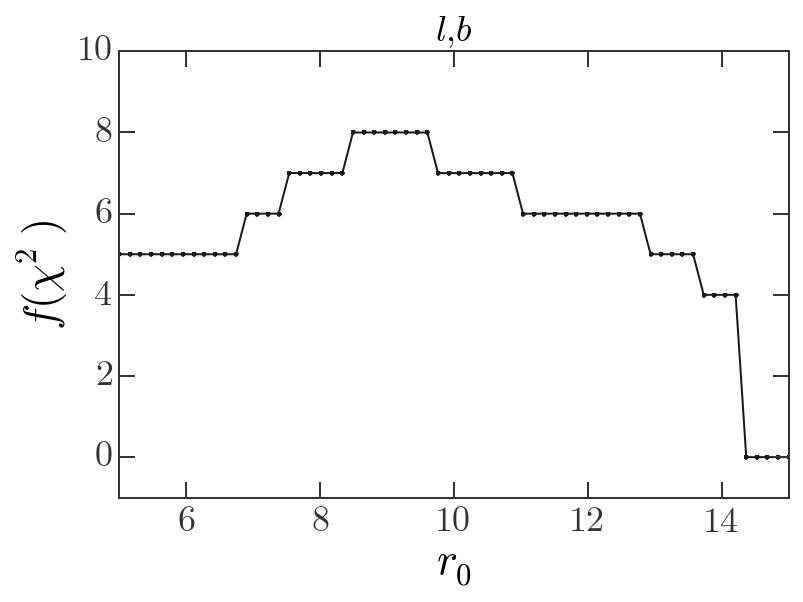

In [37]:
pl.plot(r0s, derps_lb)
pl.xlabel('$r_0$')
pl.ylabel(r'$f(\chi^2)$')
pl.xlim(5,15)
pl.ylim(-1,10)
pl.title("$l$,$b$", fontsize=18)

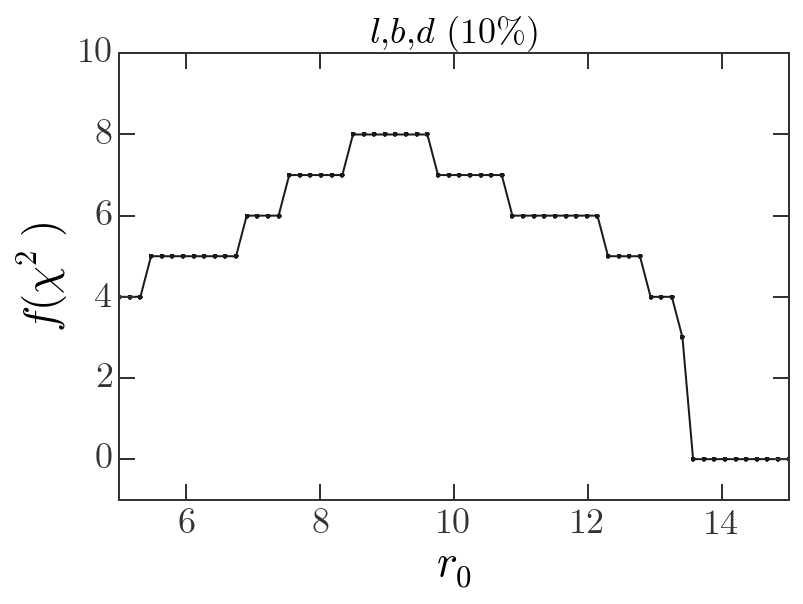

In [38]:
pl.plot(r0s, derps_lbd)
pl.xlabel('$r_0$')
pl.ylabel(r'$f(\chi^2)$')
pl.xlim(5,15)
pl.ylim(-1,10)
pl.title("$l$,$b$,$d$ (10%)", fontsize=18)

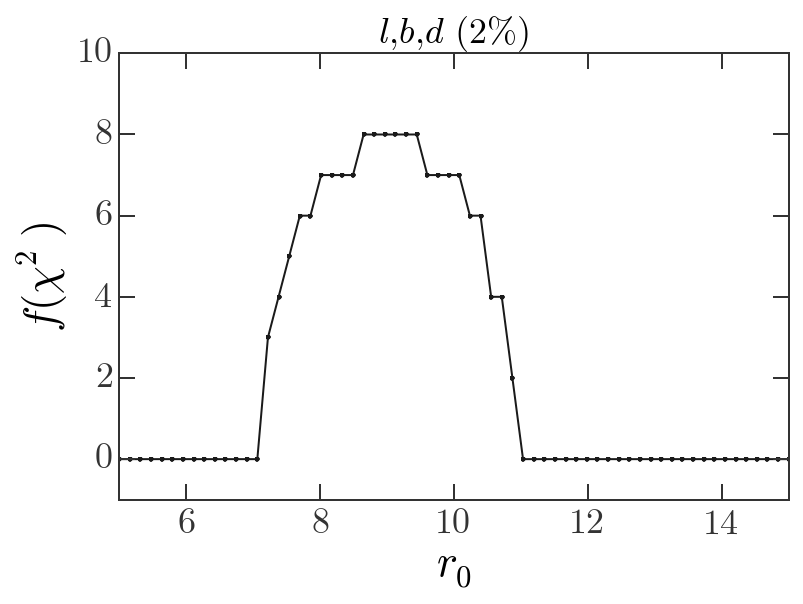

In [39]:
pl.plot(r0s, derps_lbd2)
pl.xlabel('$r_0$')
pl.ylabel(r'$f(\chi^2)$')
pl.xlim(5,15)
pl.ylim(-1,10)
pl.title("$l$,$b$,$d$ (2%)", fontsize=18)

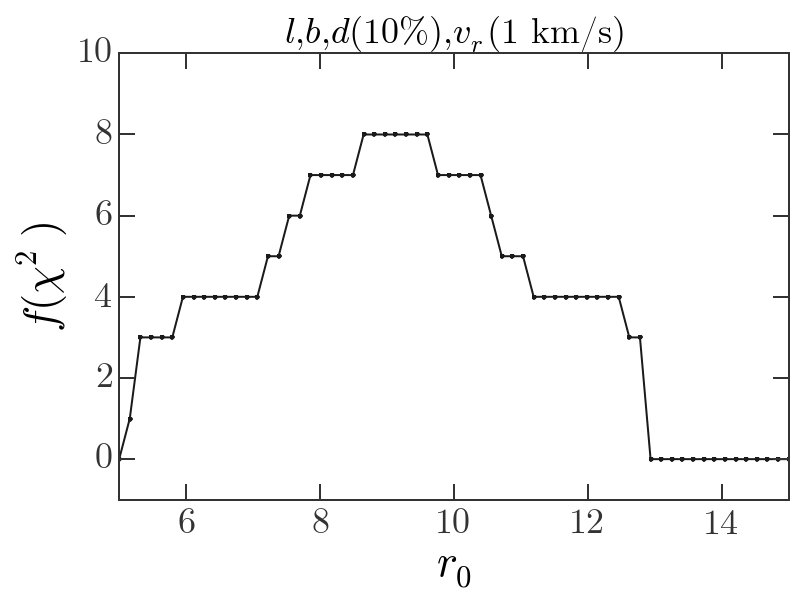

In [40]:
pl.plot(r0s, derps_lbdvr)
pl.xlabel('$r_0$')
pl.ylabel(r'$f(\chi^2)$')
pl.xlim(5,15)
pl.ylim(-1,10)
pl.title("$l$,$b$,$d$(10%),$v_r$(1 km/s)", fontsize=18)

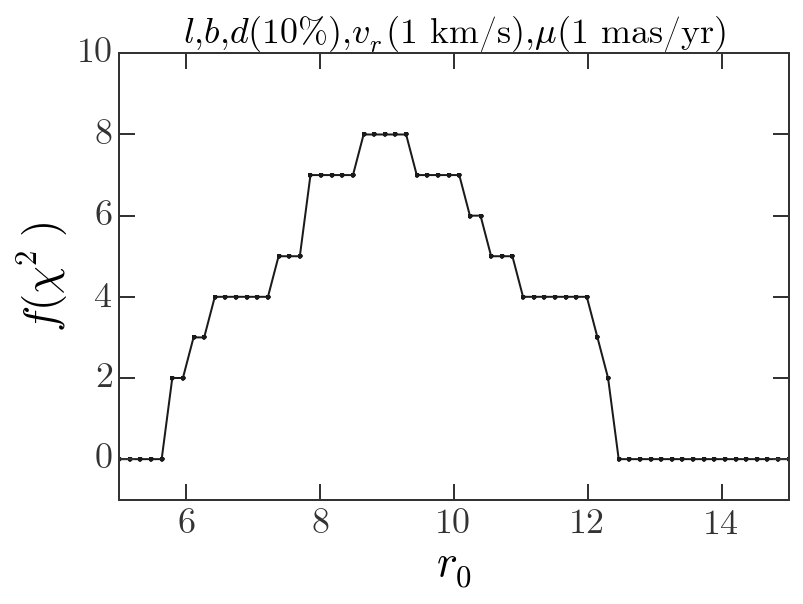

In [41]:
pl.plot(r0s, derps_lbdvrpm)
pl.xlabel('$r_0$')
pl.ylabel(r'$f(\chi^2)$')
pl.xlim(5,15)
pl.ylim(-1,10)
pl.title("$l$,$b$,$d$(10%),$v_r$(1 km/s),$\mu$(1 mas/yr)", fontsize=18)

---

In [49]:
%%prun -s cumulative

r0s = np.linspace(5,15,64)
derps = np.zeros_like(r0s)
for i,r0 in enumerate(r0s):
    _mock = kingkong.MockStream(r0=r0, v0=0.5, nsteps_per_period=128, quaternion=mock.quaternion)
    chisq_nk = _mock.compute_statistic(data)
    derps[i] = np.sum(chisq_nk.min(axis=1) < 10.)